# Review Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

# Download the vader_lexicon resource
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
data = pd.read_csv("sentiment-analysis.csv")

In [3]:
# Assuming you have a DataFrame 'df' with a column 'Text'
# Split the 'Text' column into new columns using the comma separator
data[['Text', 'Sentiment', 'Source', 'Date/Time', 'User_ID', 'Location', 'Confidence_Score']] = data['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand=True)

data.drop(columns=['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'], inplace=True)

In [4]:
data.drop(columns=['User_ID'], inplace=True)

In [5]:
data.isnull().sum()

Text                2
Sentiment           2
Source              2
Date/Time           2
Location            2
Confidence_Score    2
dtype: int64

In [6]:
data.dropna(inplace = True)
# dropna to drop the null values

df = data.copy()

<AxesSubplot:>

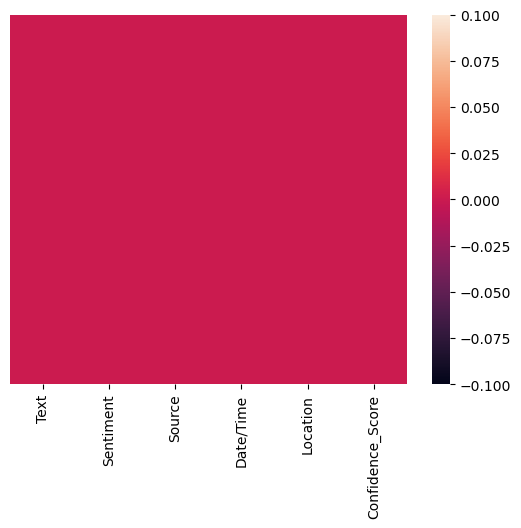

In [7]:
sns.heatmap(data.isnull(), yticklabels = False)

In [8]:
print('This is the shape of the date', data.shape)

This is the shape of the date (96, 6)


#### Extract Month from Data/Time column

In [9]:
def datetime(df):
    df['Date/Time'] = pd.to_datetime(df["Date/Time"])
    df['month'] = df['Date/Time'].dt.month
    df['day'] = df['Date/Time'].dt.day
    df['day_of_week'] = df['Date/Time'].dt.day_of_week
    df['day_name'] = df['Date/Time'].dt.day_name()
    df['quarter'] = df['Date/Time'].dt.quarter
    df['is_leap_year'] = df['Date/Time'].dt.is_leap_year
    return df

result = datetime(df)

## Data Visualization

In [10]:
group_location = data.groupby('Location')

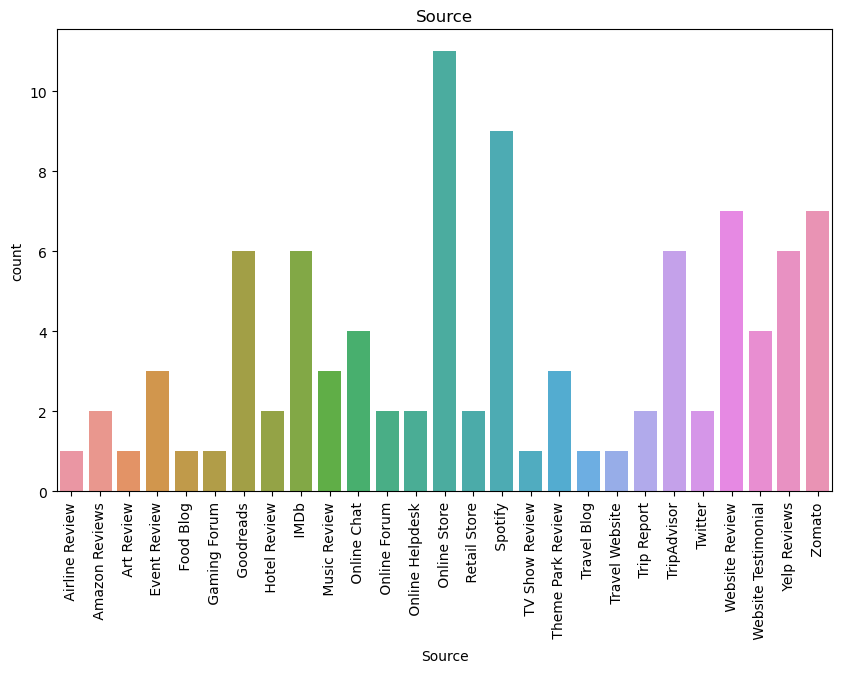

In [11]:
# Set the figure size
plt.figure(figsize=(10, 6)) 
sns.countplot(data=data, x = data['Source'].sort_values())
plt.title('Source')
plt.xticks(rotation=90)  # Specify the rotation angle in degrees
plt.show()

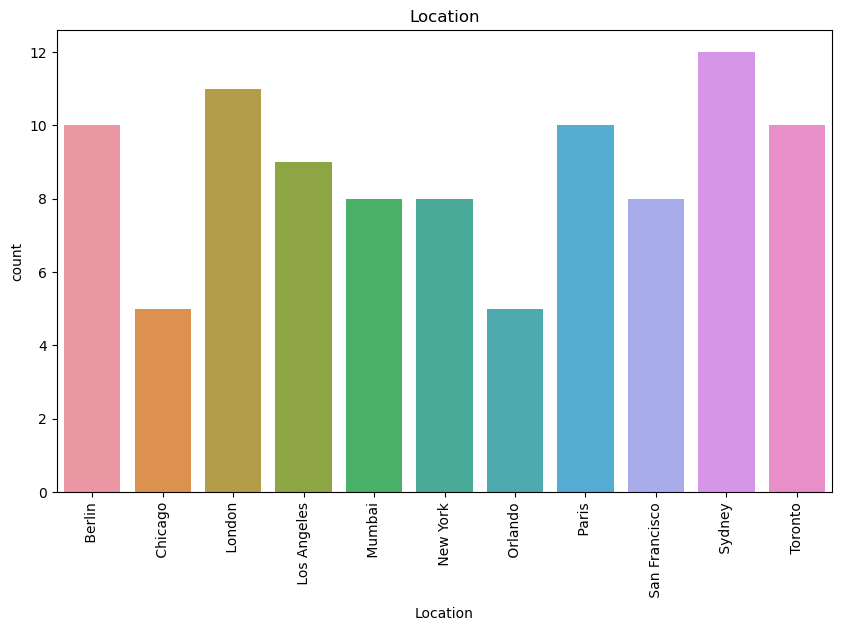

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6)) 
sns.countplot(data=data, x = data['Location'].sort_values())
plt.title('Location')
plt.xticks(rotation=90)  # Specify the rotation angle in degrees
plt.show()

## Distribution frequency

In [13]:
data["Confidence_Score"].agg(["min","mean","median","max","std","skew"]).to_frame().T

C:\Users\danie\AppData\Local\Temp\ipykernel_12384\3505733675.py:1: FutureWarning: ['mean', 'std'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data["Confidence_Score"].agg(["min","mean","median","max","std","skew"]).to_frame().T


,min,median,max,skew
Confidence_Score,0.55,0.86,0.95,-0.370143


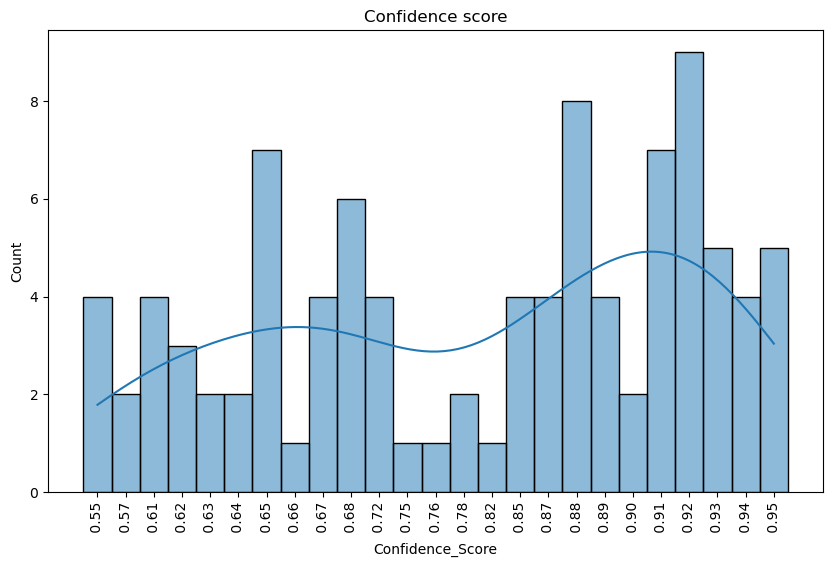

In [14]:
# Set the figure size
plt.figure(figsize=(10, 6)) 
sns.histplot(data=data, x=data['Confidence_Score'].sort_values(), kde=True)
plt.title('Confidence score')
plt.xticks(rotation=90)  # Specify the rotation angle in degrees
plt.show()

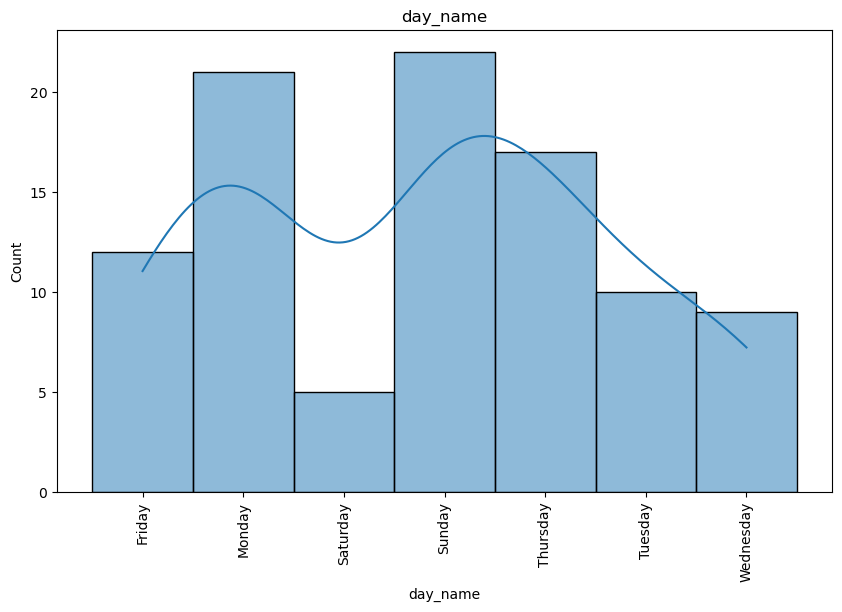

In [15]:
# Set the figure size
plt.figure(figsize=(10, 6)) 
sns.histplot(data=df, x=df['day_name'].sort_values(), kde = True)
plt.title('day_name')
plt.xticks(rotation=90)  # Specify the rotation angle in degrees
plt.show()

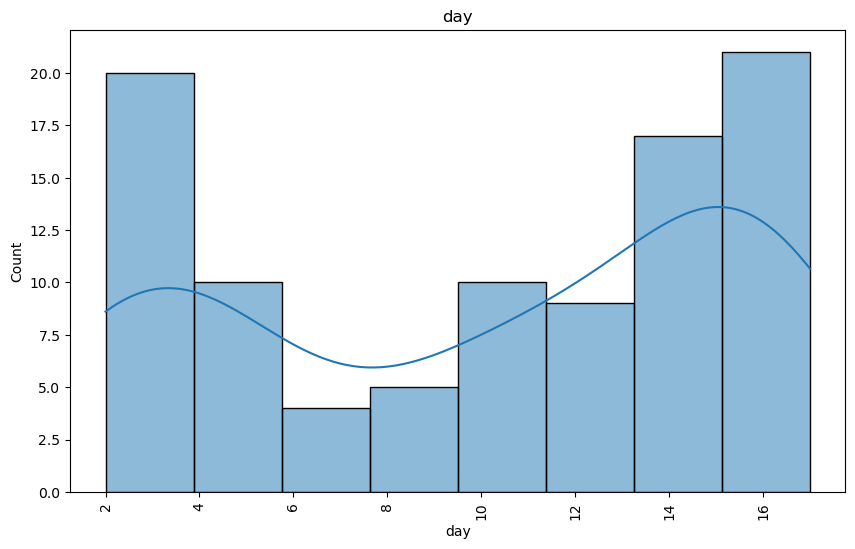

In [16]:
# Set the figure size
plt.figure(figsize=(10, 6)) 
sns.histplot(data=df, x=df['day'].sort_values(), kde = True)
plt.title('day')
plt.xticks(rotation=90)  # Specify the rotation angle in degrees
plt.show()

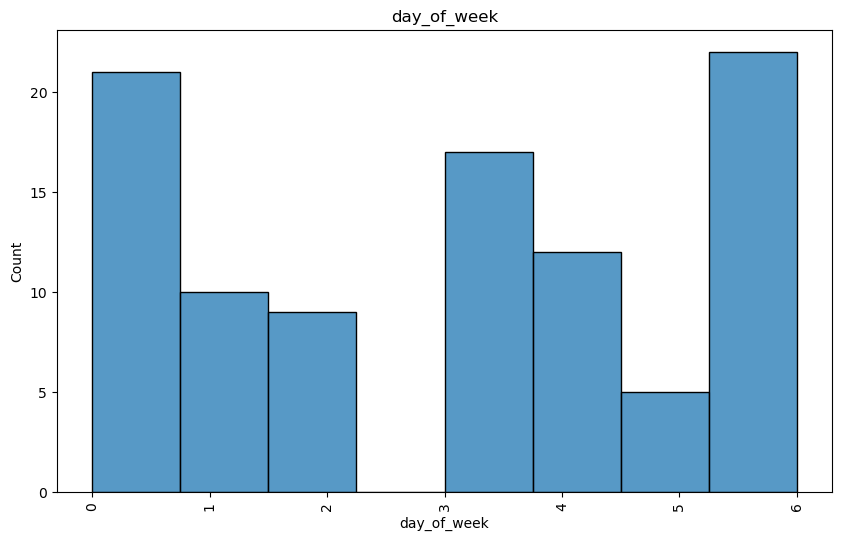

In [17]:
# Set the figure size
plt.figure(figsize=(10, 6)) 
sns.histplot(data=df, x=df['day_of_week'].sort_values())
plt.title('day_of_week')
plt.xticks(rotation=90)  # Specify the rotation angle in degrees
plt.show()

In [18]:
df = datetime(df)

## Sentiment Analysis

In [19]:
# Convert the 'Text' column to string type to handle any float values
df['Text'] = df['Text'].astype(str)

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Performing sentiment analysis on each review
sentiments = []

for review in df['Text']:
    sentiment = sia.polarity_scores(review)
    sentiments.append(sentiment)

In [21]:
sentiment_labels = []

for sentiment in sentiments:
    compound_score = sentiment['compound']
    if compound_score >= 0.05:
        sentiment_labels.append('Positive')
    elif compound_score <= -0.05:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

In [22]:
# Add the sentiment labels to the DataFrame
df['new_sentiment'] = sentiment_labels

#### Split into dependent and independent variables

In [23]:
X = df['Text']
y = df['new_sentiment']

## TfidfVectorizer and K-Fold Cross Validation

In [24]:
# Create a pipeline for sentiment analysis using TfidfVectorizer and both Logistic Regression and Random Forest Classifier
pipeline_logreg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

pipeline_randomforest = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

# Perform 5-fold cross-validation and get the accuracy scores for both pipelines
cv_scores_logreg = cross_val_score(pipeline_logreg, X, y, cv=5, scoring='accuracy')
cv_scores_randomforest = cross_val_score(pipeline_randomforest, X, y, cv=5, scoring='accuracy')

# Print the mean accuracy and standard deviation of the cross-validation scores for both pipelines
print("Logistic Regression - Mean Accuracy:", cv_scores_logreg.mean())
print("Logistic Regression - Standard Deviation:", cv_scores_logreg.std())
print("="*59)
print("Random Forest - Mean Accuracy:", cv_scores_randomforest.mean())
print("Random Forest - Standard Deviation:", cv_scores_randomforest.std())

Logistic Regression - Mean Accuracy: 0.78
Logistic Regression - Standard Deviation: 0.10326525026046925
Random Forest - Mean Accuracy: 0.7789473684210526
Random Forest - Standard Deviation: 0.1835325870964494


#### Comparing Sentiment analysis (Old & New)

In [25]:
df_sent = df['Sentiment'].value_counts()
df_sent

 Positive    53
 Negative    43
Name: Sentiment, dtype: int64

In [26]:
df_sent1 = df['new_sentiment'].value_counts()
df_sent1

Positive    43
Negative    33
Neutral     20
Name: new_sentiment, dtype: int64

In [28]:
df[['Text', 'Sentiment', 'new_sentiment']]

,Text,Sentiment,new_sentiment
0,"""I love this product!""",Positive,Positive
1,"""The service was terrible.""",Negative,Neutral
2,"""This movie is amazing!""",Positive,Neutral
3,"""I'm so disappointed with their customer suppo...",Negative,Negative
4,"""Just had the best meal of my life!""",Positive,Positive
...,...,...,...
91,"""Just had the most amazing vacation! I can't w...",Positive,Positive
92,"""The food at this restaurant was awful. Never ...",Negative,Negative
93,"""I can't stop listening to this song. It's my ...",Positive,Positive
94,"""Their website is so confusing and poorly desi...",Negative,Negative


### Splitting Training set and Test set

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### TdifVector

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Classification Models

In [31]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression classifier
classifier = LogisticRegression()

# Fit the classifier to the training data
classifier.fit(X_train_vec, y_train)

# Now the model is trained and you can use it for predictions on the test data
y_pred = classifier.predict(X_test_vec)

#### Evaulation of the model

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)
accuracy_1 = accuracy_score(y_test, y_pred)*100
recall_1 = recall_score(y_test, y_pred, average='weighted')
precision_1 = precision_score(y_test, y_pred, average='weighted')*100
f1score_1 = f1_score(y_test, y_pred, average='weighted')

print(f'This is the model accuracy: {accuracy_1}%')
print('The precision of the model:', precision_1)
print('The recall of the model:', recall_1)
print('The f score of the model:', f1score_1)
print("="*53)
print("Classification Report:")
print("="*53)
print(classification_report(y_test, y_pred))

This is the model accuracy: 80.0%
The precision of the model: 81.11538461538463
The recall of the model: 0.8
The f score of the model: 0.7947222222222222
Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      1.00      0.75         3
     Neutral       0.50      0.33      0.40         3
    Positive       0.92      0.86      0.89        14

    accuracy                           0.80        20
   macro avg       0.67      0.73      0.68        20
weighted avg       0.81      0.80      0.79        20



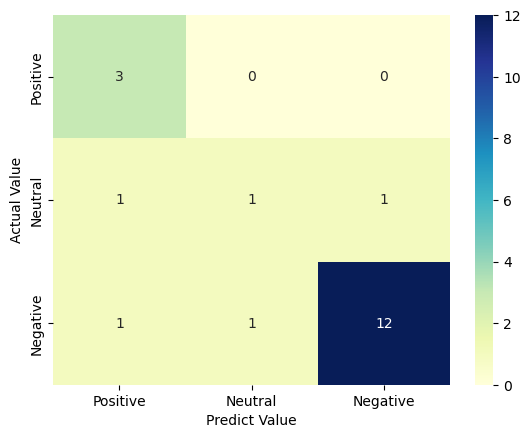

In [33]:
sns.heatmap(cm, annot = True, cmap = "YlGnBu",
           xticklabels=["Positive", "Neutral", "Negative"],
           yticklabels=["Positive", "Neutral", "Negative"])

plt.xlabel("Predict Value")
plt.ylabel("Actual Value")
plt.show()

### Validation machine

In [34]:
def predict_sentiment(review):
    review_vec = vectorizer.transform([review])
    sentiment = classifier.predict(review_vec)
    return sentiment[0]

##### Sampling model

In [35]:
new_review = "This restaurant has excellent service and delicious food."
predicted_sentiment = predict_sentiment(new_review)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: Positive


In [36]:
new_review2 = "This restaurant sucks."
predicted_sentiment = predict_sentiment(new_review2)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: Negative


## Word Cloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


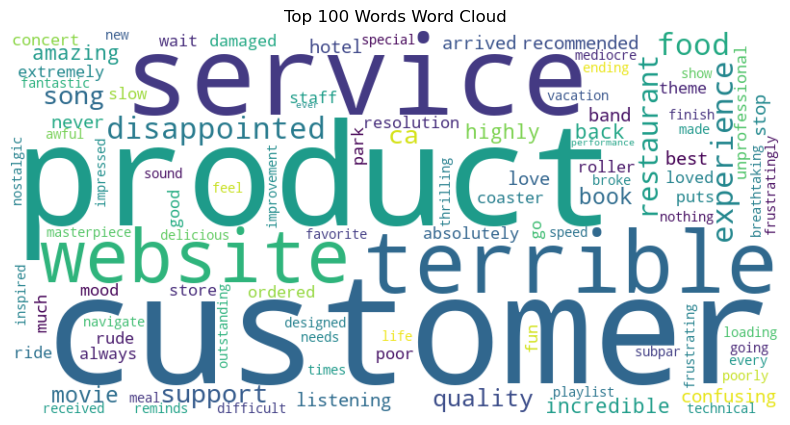

In [46]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud


# Combine all text into a single string
all_text = " ".join(df['Text'].tolist())

# Tokenize the text
tokens = word_tokenize(all_text)

# Convert words to lowercase and remove stopwords and punctuation
stop_words = set(stopwords.words('english'))
tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

# Count the frequency of each word
word_freq = Counter(tokens)

# Select the top 10 most frequent words
top_words = word_freq.most_common(100)

# Convert the top words to a dictionary for WordCloud
wordcloud_dict = dict(top_words)

# Create the Word Cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Words Word Cloud')
plt.show()